In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
os.chdir(wd)
sys.path.insert(0, eyefuncdir)
import eyefuncs as eyes

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26])
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
eyetimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'glm1', 'eyetracker_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', 'glm1', 'regressor_names.npy'))
regnames = np.array(['mean', 'precision', 'amplitude'])
nparams = regnames.size
#ppts x tuning curve timepoints x regressors x
b = np.zeros(shape = [nsubs, modeltimes.size, nparams, eyetimes.size]) * np.nan
t = np.zeros(shape = [nsubs, modeltimes.size, nparams, eyetimes.size]) * np.nan

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
use_b = True
if use_b:
    addtext = 'modelB1beta'
elif not use_b:
    addtext = 'modelB1tvalue'
fittype = 'opt'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'
b = np.zeros(shape = [nsubs, modeltimes.size, regnames.size, eyetimes.size]) * np.nan
t = np.zeros_like(b) * np.nan
subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'glm1', f'wmc_s{sub:02d}_glm1_betas_{fittext}_{addtext}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'glm1', f'wmc_s{sub:02d}_glm1_tvalues_{fittext}_{addtext}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants

<font color='red'>

first we're going to just quickly visualise what the average pupil-evoked response is to the array appearing, just to visualise what this looks like

Text(0.5, 0, 'time relative to array onset (s)')

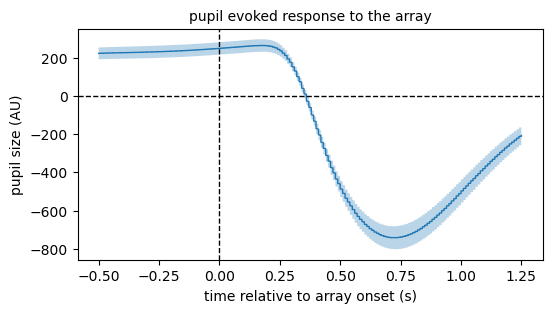

In [3]:
#quickly just visualise what the average pupil-evoked response is to the array
plotd = b[:, :, 0, :] #take just the intercept
plotd = np.nanmean(plotd, axis=1) #average across tuning curve time, results in [ppts x eyetracker time]
plotm = plotd.mean(0)
plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

fig = plt.figure(figsize = [6,3])
ax = fig.add_subplot(111)
ax.plot(eyetimes, plotm, lw = 1)
ax.fill_between(eyetimes,
                np.add(plotm, plotsem),np.subtract(plotm, plotsem),
                alpha=0.3, edgecolor=None)
ax.axhline(0, lw=1, ls='dashed', color='k')
ax.axvline(0, lw =1, ls='dashed', color='k')
ax.set_title('pupil evoked response to the array', fontsize=10)
ax.set_ylabel('pupil size (AU)')
ax.set_xlabel('time relative to array onset (s)')

<font color='red'>

modelling of the relationship between tuning curve parameters and pupil dilation are done in a 2d fashion, per time point in both the tuning curve parameter timecourse and the pupil response. as a result, there is a beta for each combination of time, and these parameters can be visualised as a 2d image, separately for each regressor in the fitted model


<font color='red'>

for the figures below, we are assuming the following process:

- tuning curve parameters are estimated in a two stage process:
    - first, alpha is fit on the rescaled data (minmax scaled)
    - second, the estimated alpha is smoothed lightly and used in a second fitting stage where B1 is estimated on the demeaned data
    - this second stage is fit using an optimisation algorithm

we are plotting the mean pupil response (intercept of the glm), and the 2d imshow for the regressors of alpha parameter, and the estimated value of B1 in the second stage

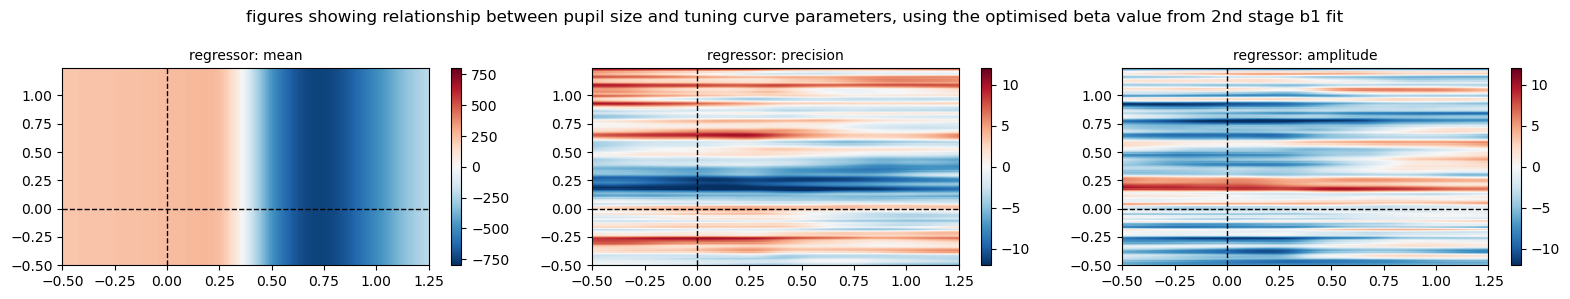

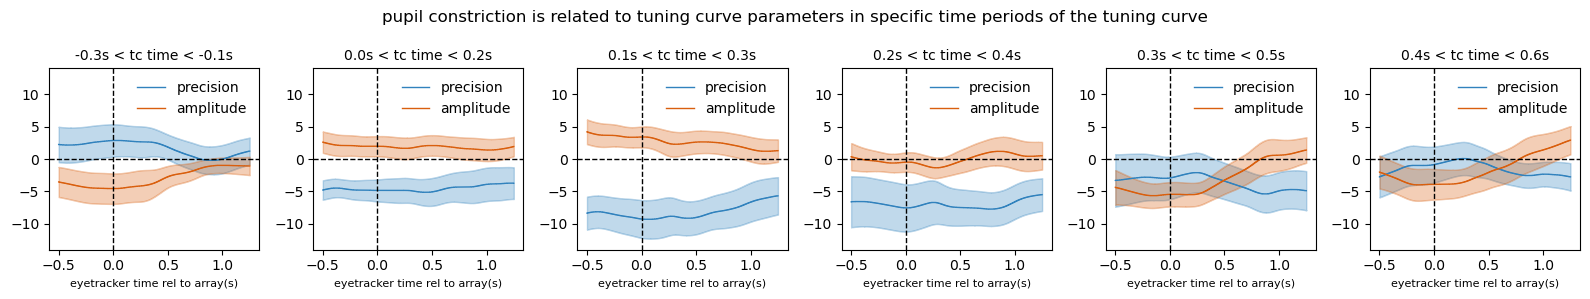

In [4]:
fig = plt.figure(figsize = [16, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -800, 800
    else:
        vmin, vmax = -12, 12
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(bm[:,iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.suptitle('figures showing relationship between pupil size and tuning curve parameters, using the optimised beta value from 2nd stage b1 fit', fontsize = 12)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = b[:, tinds].mean(axis=1) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < tc time < {iend}s', fontsize = 10)
    ax.set_ylim([-14, 14])
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 8)
    ax.legend(loc = 'upper right', frameon=False)
fig.suptitle('pupil constriction is related to tuning curve parameters in specific time periods of the tuning curve', fontsize = 12)
fig.tight_layout()

<font color='red'>

here, the 2d representations of the beta-weights from the regression that models the association between pupil size and tuning curve parameters lets us see if there are pockets of time that stand out, or are important. Along the x-axis is eyetracker time, and the y-axis is tuning curve time.

If you were to take a specific horizontal band and plot it as a time series (as above), it would be asking how tuning curve parameters (precision/amplitude) in a specific time of EEG processing covary with the pupil response over time.

If, instead, you took a vertical band (e.g. averaged over the vertical band pre-array onset) and plotted it as a time series, you would be asking how pupil dilation in that time period is related to the modelled tuning curve parameters across time (e.g. how is baseline pupil size related to tuning curve amplitude or precision across time)

<font color='red'>

so, the alternative way of doing this is to flip axes: rather than saying where are the tuning curve parameters related to pupil dilation, instead we can say, for example: where does baseline pupil size influence the tuning curve parameters over time?


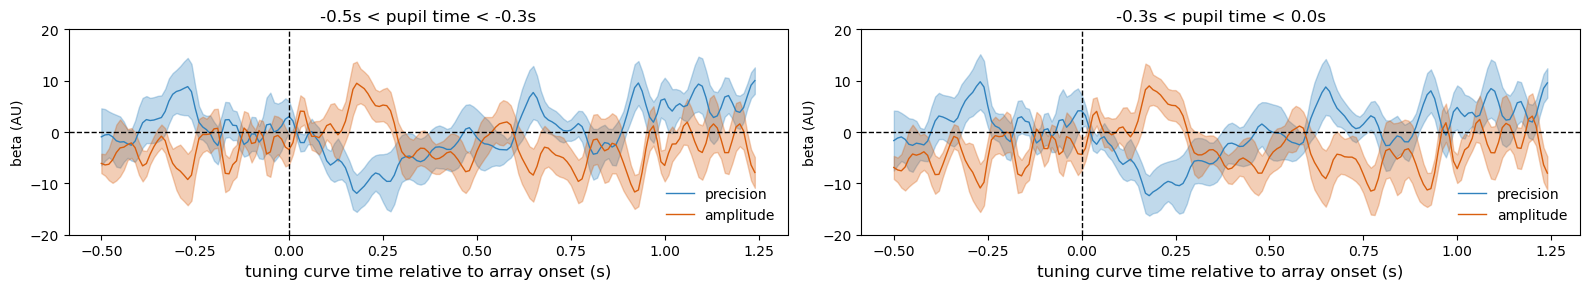

In [5]:
mstarts = [-0.5, -0.3]
mends   = [-0.3,  0.0]

nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    plotd = b[:,:,:, tinds].mean(-1).transpose(0, 2, 1) #average across the timewindow in the pupil axis and reshape to be [ppts x parameters x times]
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(modeltimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 12)
    ax.set_ylim([-20, 20])
    ax.set_xlabel('tuning curve time relative to array onset (s)', fontsize = 12)
    ax.set_ylabel('beta (AU)')
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()

<font color='red'>

this nicely highlights that the influence of baseline pupil size is quite temporally specific. baseline pupil size is **_negatively_** related to tuning curve precision - more constriction ~ increased precision (more orientation preference, sharper tuning curve) - during the period of visual processing (100-500ms post array onset).

<font color='blue'>

This modelling approach can also be run in a way where rather than using the optimised value of b1 as the single-trial regressor, we use the **t value** for this optimised parameter instead (where $t = beta/stderr(beta)$). This means that where the beta was large, but highly variable in its fit, the tvalue is low. this should make us less sensitive to trials where the B1 fit was noisy

Below are the figures using the previous approach, but where the single-trial t-value for estimated B1 was used, rather than the b1 value

In [6]:
use_b = False
if use_b:
    addtext = 'modelB1beta'
elif not use_b:
    addtext = 'modelB1tvalue'
fittype = 'opt'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'
b = np.zeros(shape = [nsubs, modeltimes.size, regnames.size, eyetimes.size]) * np.nan
t = np.zeros_like(b) * np.nan
subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'glm1', f'wmc_s{sub:02d}_glm1_betas_{fittext}_{addtext}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'glm1', f'wmc_s{sub:02d}_glm1_tvalues_{fittext}_{addtext}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants

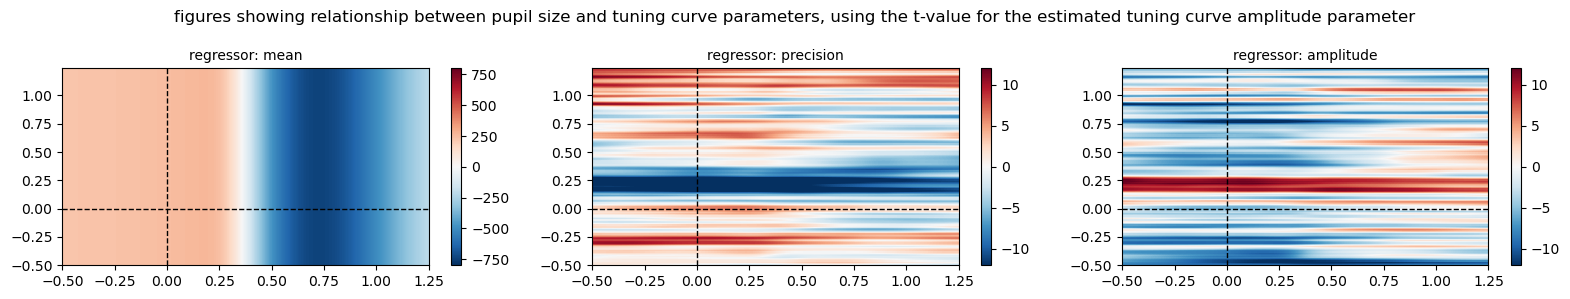

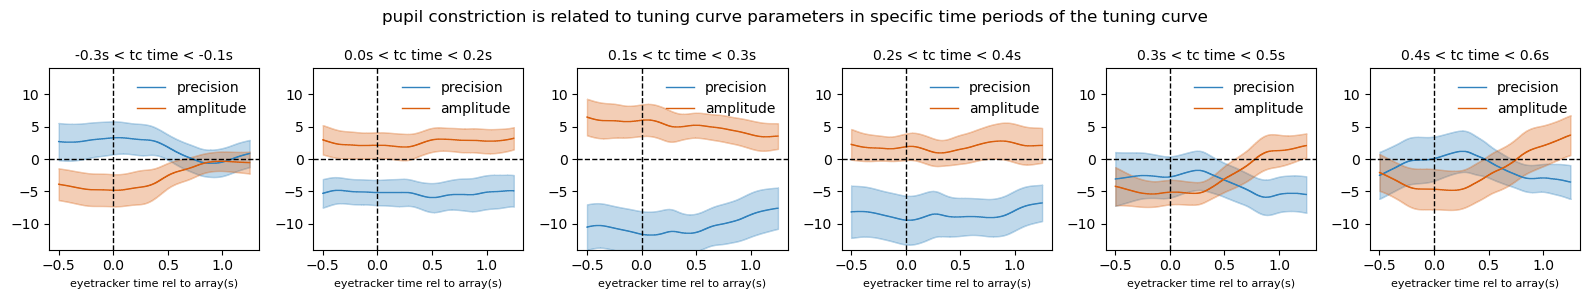

In [7]:
fig = plt.figure(figsize = [16, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -800, 800
    else:
        vmin, vmax = -12, 12
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(bm[:,iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.suptitle(f'figures showing relationship between pupil size and tuning curve parameters, using the t-value for the estimated tuning curve amplitude parameter', fontsize = 12)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = b[:, tinds].mean(axis=1) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < tc time < {iend}s', fontsize = 10)
    ax.set_ylim([-14, 14])
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 8)
    ax.legend(loc = 'upper right', frameon=False)
fig.suptitle('pupil constriction is related to tuning curve parameters in specific time periods of the tuning curve', fontsize = 12)
fig.tight_layout()

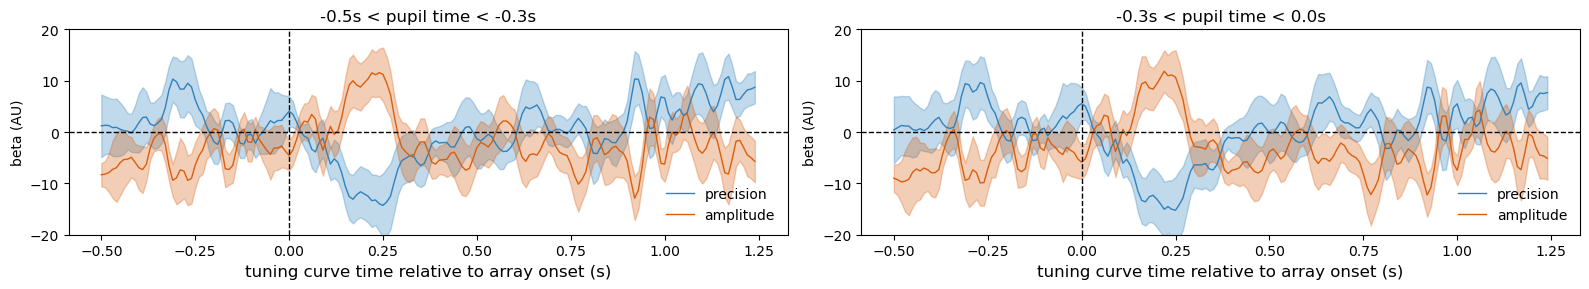

In [8]:
mstarts = [-0.5, -0.3]
mends   = [-0.3,  0.0]

nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    plotd = b[:,:,:, tinds].mean(-1).transpose(0, 2, 1) #average across the timewindow in the pupil axis and reshape to be [ppts x parameters x times]
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(modeltimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 12)
    ax.set_ylim([-20, 20])
    ax.set_xlabel('tuning curve time relative to array onset (s)', fontsize = 12)
    ax.set_ylabel('beta (AU)')
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()